### Index
1. Importing Libraries
2. Data and it's preprocessing
3. Model
4. Model's 50 lowest confidence predictions
5. HopSkipJump
6. CopyCatCNN
7. Adverserial Dataset
8. Defense

### Importing Libraries

In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
from art.estimators.classification import TensorFlowV2Classifier
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import pickle
from art.attacks.evasion import HopSkipJump
from art.estimators.classification import TensorFlowV2Classifier
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import load_model

c:\Users\dangw\anaconda3\envs\mnist\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\dangw\anaconda3\envs\mnist\lib\site-packages\art\estimators\certification\__init__.py:30: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


### Data and it's preprocessing

In [2]:
# Load all batches
file_path = r'..\..\3. CIFER-100\cifar-100-python\cifar-100-python\train'
with open(file_path, 'rb') as f:
    data_dict = pickle.load(f, encoding='latin1')

# The data_dict will conwtain the images and their corresponding labels
print(data_dict.keys())  

dict_keys(['filenames', 'batch_label', 'fine_labels', 'coarse_labels', 'data'])


In [3]:
data = pd.DataFrame({
    'image_data': list(data_dict['data']),  # Each row will contain 3072 values for image data
    'fine_label': data_dict['fine_labels']  # Fine-grained labels
})

In [ ]:
# reshaping the image_data column
data['image_data'] = data['image_data'].apply(
    lambda x: np.array(x).reshape((3, 32, 32)).transpose(1, 2, 0)
)

In [5]:
data['image_data'] = data['image_data'] / 255.0

In [6]:
data['image_data'] = data['image_data'].map(lambda x: (np.round(x, 2)))

In [ ]:
# Path to the CIFAR-100 train file
file_path =r'..\..\3. CIFER-100\cifar-100-python\cifar-100-python\test'

# Load the data using pickle with the correct encoding
with open(file_path, 'rb') as f:
    test_dict = pickle.load(f, encoding='latin1')

# The data_dict will contain the images and their corresponding labels
print(test_dict.keys())

dict_keys(['filenames', 'batch_label', 'fine_labels', 'coarse_labels', 'data'])


In [8]:
test = pd.DataFrame({
    'image_data': list(test_dict['data']),  # Each row will contain 3072 values for image data
    'fine_label': test_dict['fine_labels']  # Fine-grained labels
})

In [9]:
test['image_data'] = test['image_data'].apply(
    lambda x: np.array(x).reshape((3, 32, 32)).transpose(1, 2, 0)
)

In [10]:
test['image_data'] = test['image_data'] / 255.0

In [11]:
test['image_data'] = test['image_data'].map(lambda x: (np.round(x, 2)))

In [ ]:
train_images = np.array(data['image_data'].tolist())
train_labels = np.array(data['fine_label'])  

In [ ]:
test_images = np.array(test['image_data'].tolist())  
test_labels = np.array(test['fine_label'])  

In [14]:
train_images[0].shape

(32, 32, 3)

In [ ]:
model_path = r"..\..\3. CIFER-100\models\ResNet.h5"
model = load_model(model_path, custom_objects={"SeparableConv2D": tf.keras.layers.SeparableConv2D})

In [16]:
from tensorflow.keras.optimizers import Adam

### Model

In [17]:
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

In [18]:
training = model.fit(train_images, train_labels,epochs=1)

1563/1563 [==============================] - 135s 79ms/step - loss: 0.0334 - sparse_categorical_accuracy: 0.9929


In [19]:
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)

In [20]:
# Define loss function
loss_object = CategoricalCrossentropy()

In [88]:
optimizer = tf.keras.optimizers.Adam()

In [89]:
classifier = TensorFlowV2Classifier(model=model, nb_classes=100, input_shape=(32, 32, 3), clip_values=(0, 1), loss_object=loss_object, optimizer=optimizer, channels_first=False)

In [22]:
test_images = test_images.numpy() if isinstance(test_images, tf.Tensor) else test_images

### Model's 50 lowest confidence predictions

In [23]:
predictions = model.predict(test_images)

In [24]:
confidence_score = np.max(predictions, axis=1)

In [25]:
least_confidence_indices = np.argsort(confidence_score)[:50]

In [26]:
least_confidence_images = test_images[least_confidence_indices]
least_confidence_labels = test_labels[least_confidence_indices]

In [27]:
original_preds = np.argmax(model.predict(least_confidence_images), axis=1)

# Print comparison
for i in range(50):
    print(f"Image {i}:")
    print(f"Original Label: {least_confidence_labels[i]}, "
          f"Original Pred: {original_preds[i]}, ")

Image 0:
Original Label: 50, Original Pred: 4, 
Image 1:
Original Label: 66, Original Pred: 51, 
Image 2:
Original Label: 82, Original Pred: 33, 
Image 3:
Original Label: 22, Original Pred: 45, 
Image 4:
Original Label: 85, Original Pred: 25, 
Image 5:
Original Label: 42, Original Pred: 50, 
Image 6:
Original Label: 67, Original Pred: 32, 
Image 7:
Original Label: 31, Original Pred: 64, 
Image 8:
Original Label: 9, Original Pred: 46, 
Image 9:
Original Label: 64, Original Pred: 44, 
Image 10:
Original Label: 32, Original Pred: 66, 
Image 11:
Original Label: 66, Original Pred: 67, 
Image 12:
Original Label: 3, Original Pred: 3, 
Image 13:
Original Label: 3, Original Pred: 4, 
Image 14:
Original Label: 29, Original Pred: 76, 
Image 15:
Original Label: 42, Original Pred: 59, 
Image 16:
Original Label: 31, Original Pred: 31, 
Image 17:
Original Label: 26, Original Pred: 75, 
Image 18:
Original Label: 65, Original Pred: 38, 
Image 19:
Original Label: 7, Original Pred: 7, 
Image 20:
Original

### HopSkipJump

In [30]:
original_image = np.expand_dims(test_images[24], axis=0)  # Shape (1, 32, 32, 3)
original_label = np.argmax(test_labels[24])

In [31]:
attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=50)
adversarial_image = attack.generate(original_image)

HopSkipJump: 100%|██████████| 1/1 [00:43<00:00, 43.75s/it]


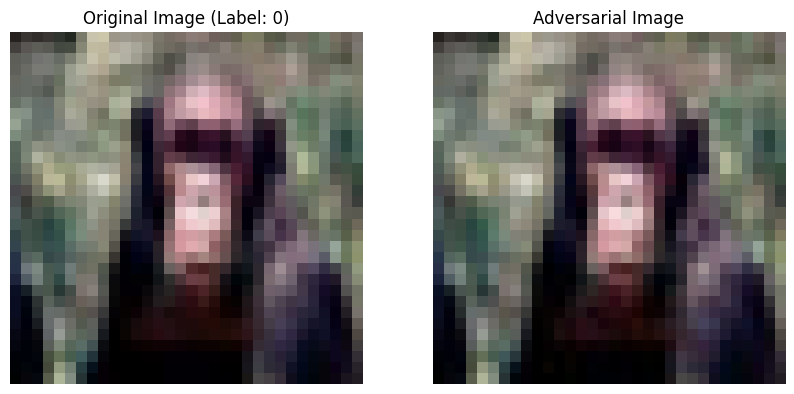

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(original_image[0])
plt.title(f"Original Image (Label: {original_label})")
plt.axis("off")

# Adversarial Image
plt.subplot(1, 2, 2)
plt.imshow(adversarial_image[0])
plt.title("Adversarial Image")
plt.axis("off")

plt.show()

In [33]:
orig_pred = np.argmax(classifier.predict(original_image))
adv_pred = np.argmax(classifier.predict(adversarial_image))

print(f"Original Prediction: {orig_pred}")
print(f"Adversarial Prediction: {adv_pred}")

Original Prediction: 21
Adversarial Prediction: 33


In [34]:
perturbation = np.mean(np.abs(original_image[0] - adversarial_image[0]))
print(f"Average perturbation: {perturbation:.10f}")  # Increased decimal places

Average perturbation: 0.0051255631


### CopyCatCNN

In [51]:
# Define loss and optimizer
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [52]:
@tf.function
def train_step(model, x, y):
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = loss_object(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [56]:

# Initialize the ART classifier with explicit train_step
classifier2 = TensorFlowV2Classifier(
    model=model,
    nb_classes=100,  # CIFAR-100 has 100 classes
    input_shape=(32, 32, 3),
    clip_values=(0, 1),
    loss_object=loss_object,
    optimizer=optimizer,  # ✅ Explicit optimizer
    train_step=train_step,  # ✅ Explicit train_step
    channels_first=False
)

In [57]:
from art.attacks.extraction import CopycatCNN
cc_attack = CopycatCNN(classifier = classifier2, batch_size_fit=5, 
                        batch_size_query=10,
                        nb_epochs=5,
                        nb_stolen=100)

In [58]:
x_extr,y_extr = train_images[:5000], train_labels[:5000]

In [59]:
stolen_classifier = cc_attack.extract(x_extr,y_extr,thieved_classifier=classifier)

In [60]:
stolen_classifier._model.evaluate(test_images,test_labels)

313/313 [==============================] - 8s 23ms/step - loss: 2.0708 - sparse_categorical_accuracy: 0.6127


[2.070765733718872, 0.6126999855041504]

### Adversarial Dataset

In [92]:
# Assuming test_images is a NumPy array of shape (num_samples, height, width, channels)
num_samples = test_images.shape[0]

# Select 500 random indices without replacement
random_indices = np.random.choice(num_samples, 100, replace=False)

# Select corresponding images
selected_images = test_images[random_indices]

In [93]:
selected_labels = test_labels[random_indices]

In [94]:
attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=15)
adversarial_data = attack.generate(selected_images)

HopSkipJump: 100%|██████████| 100/100 [13:01<00:00,  7.81s/it]


In [97]:
predictions = classifier.predict(adversarial_data)
predicted_labels = np.argmax(predictions, axis=1)
accuracy_adv = np.mean(predicted_labels == selected_labels) * 100
print(f"Accuracy on adversarial data: {accuracy_adv:.2f}%")

Accuracy on adversarial data: 11.00%


### Defense

In [ ]:
from art.defences.trainer import AdversarialTrainer

In [99]:
trainer = AdversarialTrainer(classifier=classifier, attacks=attack)

In [128]:
samples_per_class = 3
num_classes = 100

x_train_selected = []
y_train_selected = []

for class_label in range(num_classes):
    class_indices = np.where(train_labels == class_label)[0]
    
    if len(class_indices) < samples_per_class:
        print(f"Warning: Class {class_label} has only {len(class_indices)} samples, selecting all.")
        selected_indices = class_indices
    else:
        selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)
    
    # Append selected samples
    x_train_selected.append(train_images[selected_indices])
    y_train_selected.append(train_labels[selected_indices])

# Convert lists to NumPy arrays
x_train_selected = np.concatenate(x_train_selected, axis=0)
y_train_selected = np.concatenate(y_train_selected, axis=0)

print(f"Selected dataset shape: {x_train_selected.shape}, {y_train_selected.shape}")




Selected dataset shape: (300, 32, 32, 3), (300,)


In [104]:
trainer.fit(x_train_selected, y_train_selected, epochs=1, batch_size=32)

Adversarial training epochs: 100%|██████████| 20/20 [1:59:46<00:00, 359.34s/it]


In [106]:
predictions = trainer.predict(adversarial_data)
predicted_labels = np.argmax(predictions, axis=1)
accuracy_adv = np.mean(predicted_labels == selected_labels) * 100
print(f"Accuracy after adversarial data: {accuracy_adv:.2f}%")

Accuracy after adversarial data: 36.00%


In [107]:
from art.defences.preprocessor import FeatureSqueezing

# Initialize Feature Squeezing (reduce bit depth)
feature_squeezer = FeatureSqueezing(bit_depth=5, apply_fit=False, apply_predict=True, clip_values=(0,1))

# Apply both defenses
x_test_squeezed, _ = feature_squeezer(test_images)

In [116]:
predictions = trainer.predict(x_test_squeezed)
predicted_labels = np.argmax(predictions, axis=1)
accuracy_adv = np.mean(predicted_labels == test_labels) * 100
print(f"Accuracy after FeatureSqueezing data: {accuracy_adv:.2f}%")

Accuracy after FeatureSqueezing data: 41.33%


In [118]:
from art.defences.preprocessor import GaussianAugmentation

In [119]:
noiser = GaussianAugmentation(sigma=0.1)

In [124]:
x_train_noisy, y_train_noisy = noiser(x_train_selected, y_train_selected)

In [125]:
trainer.fit(x_train_noisy, y_train_noisy, nb_epochs=5)

Adversarial training epochs: 100%|██████████| 5/5 [1:31:24<00:00, 1097.00s/it]


In [127]:
predictions = trainer.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
accuracy_noisy = np.mean(predicted_labels == test_labels) * 100
print(f"Accuracy after Randomized Smoothing data: {accuracy_noisy:.2f}%")

Accuracy after Randomized Smoothing data: 40.35%


In [ ]:
trainer.fit(x_train_selected, y_train_selected, epochs=1, batch_size=32)

In [131]:
predictions = trainer.predict(adversarial_data)
predicted_labels = np.argmax(predictions, axis=1)
accuracy_adv = np.mean(predicted_labels == selected_labels) * 100
print(f"Accuracy after adversarial data: {accuracy_adv:.2f}%")

Accuracy after adversarial data: 45.00%
